# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

EPS = 1.0e-7

In [4]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# mount drive: WE NEED IT FOR SAVING IMAGES!
#from google.colab import drive

#drive.mount("/content/gdrive")

In [5]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
results_dir = "/content/gdrive/My_Drive/Colab Notebooks/TEACHING/"

In [6]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

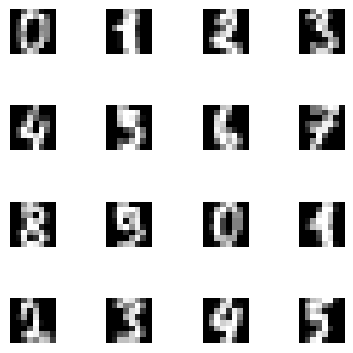

In [7]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [8]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [9]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        log_probs = self.classnet(x) # log_probs = log(softmax(x))
        y_pred = log_probs.argmax(dim=1) # y_pred = argmax(log_probs)
        
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        log_probs = self.classnet(x) # log_probs = log(softmax(x))
        # PLEASE FILL IN
        loss = self.nll(log_probs, y) # loss = nll(log_probs, y)
        # ------
        if reduction == "sum":
            return loss.sum()
        return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:**
The objective function for a classification task is usually a function with loss where the model tries to minimize. In the specific case above, nn.NLLLoss is Negative Log Likelihood Loss. This is used for classification problems where classes are mutually exclusive. The mathematical form is:

L(y, f(x)) = -log(f(x)[y])

Here, y is the true class label, f(x) is the predicted probability distribution across classes for data point x, and f(x)[y] is the predicted proabbility for the true class.

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** As far as I know, yes it is correct to use log-softmax instead of softmax. This is because the softmax function outputs a vector that representes the probability distributions of a list of potential outcomes. This is beneficial in a multi-class classification where we want to identify the likelihood of each outcome. Taking the log of the softmax output can be useful for numerical stability, as softmax of a large input vector is bound to have numerical issues.

### 2.2 Evaluation

In [10]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        test_targets=test_targets.long()
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [11]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            targets=targets.long()
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [12]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [13]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [14]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader)) # get a batch of data
print(f"Feature batch shape: {train_features.size()}") # batch size x features
print(f"Labels batch shape: {train_labels.size()}") # batch size x 1

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8)) # 1 channel, 8x8 image
train_features_reshaped = reshape(train_features) # reshape the batch
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}") # batch size x channels x height x width

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten() # flatten the batch
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}") # batch size x (channels x height x width)

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [15]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=0.6601574271065849, val ce=0.14
Epoch: 10, val nll=0.12186694622039795, val ce=0.02857142857142857
Epoch: 20, val nll=0.11482379879270281, val ce=0.03142857142857143
Epoch: 30, val nll=0.10996226583208357, val ce=0.03142857142857143
Epoch: 40, val nll=0.11025245189666748, val ce=0.03428571428571429
Epoch: 50, val nll=0.11000139934676034, val ce=0.03142857142857143
-> FINAL PERFORMANCE: nll=0.29291304965947296, ce=0.06487695749440715


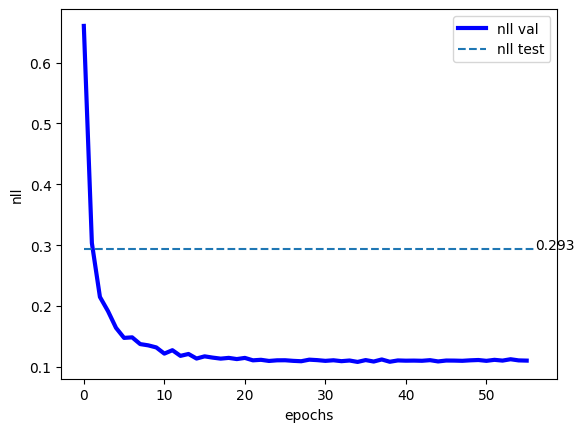

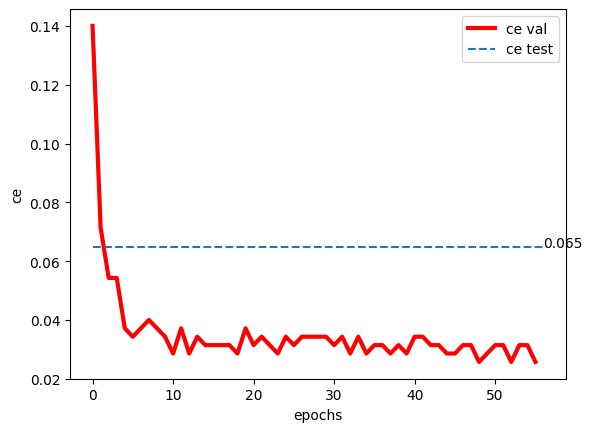


-> START classifier_cnn
Epoch: 0, val nll=0.8985493741716657, val ce=0.10857142857142857
Epoch: 10, val nll=0.12046179703303746, val ce=0.02857142857142857
Epoch: 20, val nll=0.08265873840876987, val ce=0.017142857142857144
Epoch: 30, val nll=0.07092061553682599, val ce=0.022857142857142857
Epoch: 40, val nll=0.06011816126959665, val ce=0.017142857142857144
Epoch: 50, val nll=0.05809075491768973, val ce=0.02
Epoch: 60, val nll=0.05550935847418649, val ce=0.02
Epoch: 70, val nll=0.052635612658091954, val ce=0.02
Epoch: 80, val nll=0.051382128851754326, val ce=0.02
Epoch: 90, val nll=0.05130348461014884, val ce=0.02
Epoch: 100, val nll=0.05096979635102408, val ce=0.02
Epoch: 110, val nll=0.049427971839904786, val ce=0.02
Epoch: 120, val nll=0.04969875599656786, val ce=0.02
Epoch: 130, val nll=0.04952173011643546, val ce=0.02
Epoch: 140, val nll=0.0490094769852502, val ce=0.02
Epoch: 150, val nll=0.04838494411536626, val ce=0.022857142857142857
-> FINAL PERFORMANCE: nll=0.204121168027788

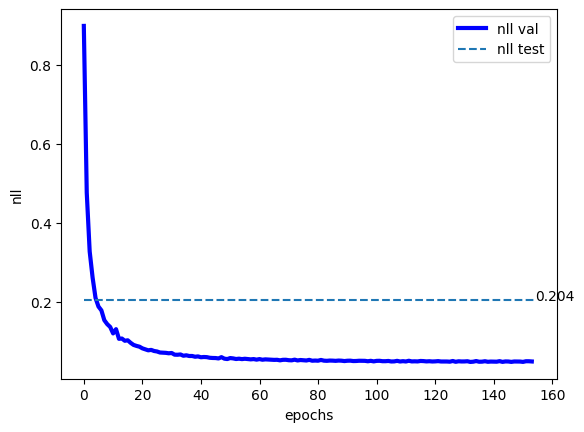

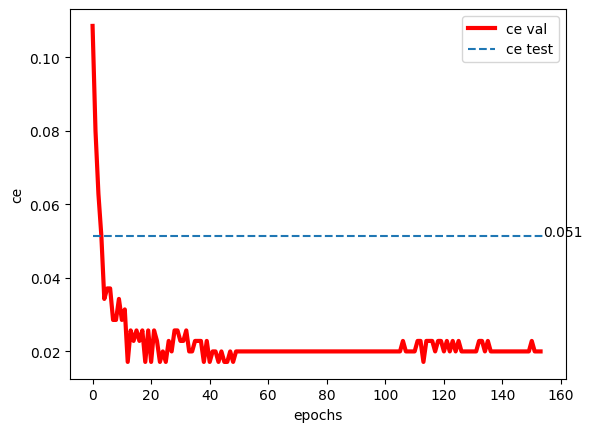

In [16]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)


    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
        nn.Linear(D, M),   # Input layer: D input features, M hidden units
        nn.ReLU(),         # Activation function: ReLU
        nn.Linear(M, M),   # Hidden layer: M hidden units
        nn.ReLU(),         # Activation function: ReLU
        nn.Linear(M, K),   # Output layer: M hidden units, K output classes
        nn.LogSoftmax(dim=1)  # LogSoftmax activation for classification
    )

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
        Reshape(size=(1, 8, 8)),        # Reshape input images to the appropriate size
        nn.Conv2d(1, num_kernels, 3),   # Convolutional layer with num_kernels kernels of size 3x3
        nn.ReLU(),                      # Activation function: ReLU
        nn.MaxPool2d(2),                # Max pooling layer with kernel size 2x2
        Flatten(),                      # Flatten the output for fully connected layers
        nn.Linear(num_kernels * 3 * 3, M),  # Fully connected layer with M neurons
        nn.ReLU(),                      # Activation function: ReLU
        nn.Linear(M, K),               # Output layer: M hidden units, K output classes
        nn.LogSoftmax(dim=1)           # LogSoftmax activation for classification
)

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True], # only parameters that require gradients
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training( # nll_val and error_val are used for plotting
        name=result_dir + name, # name of the file
        max_patience=max_patience, # early stopping
        num_epochs=num_epochs, # number of epochs
        model=model, # model
        optimizer=optimizer, # optimizer
        training_loader=training_loader, # training data
        val_loader=val_loader, # validation data
    )

    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader) # test_loader is the test data

    f = open(result_dir + name + "_test_loss.txt", "w") # save the test loss and error
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()

    plot_curve( # plot the curves
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: The graphs looks to show that the CNN's convergence is faster than MLP in terms of both the loss function and the classification error. The CNN's loss function starts lower and reaches its minimum value much faster than MLP's loss function. And, the CNN's classification error starts higher than the MLP's classification error but decreases faster and reaches a lower minimum value.

![Screenshot 2024-05-15 132443.png](<attachment:Screenshot 2024-05-15 132443.png>)
![Screenshot 2024-05-15 132446.png](<attachment:Screenshot 2024-05-15 132446.png>)
![Screenshot 2024-05-15 132516.png](<attachment:Screenshot 2024-05-15 132516.png>)
![Screenshot 2024-05-15 132520.png](<attachment:Screenshot 2024-05-15 132520.png>)
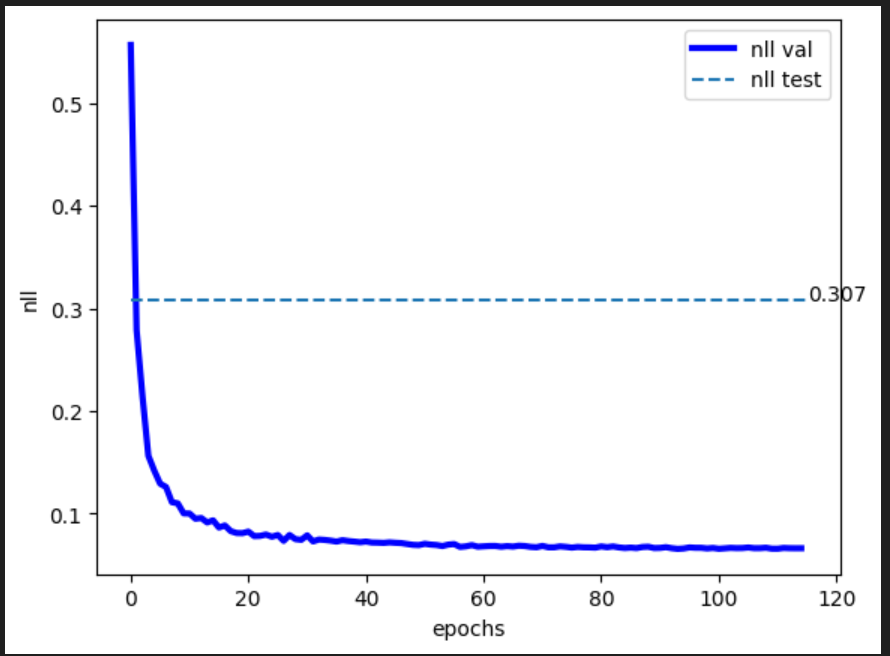
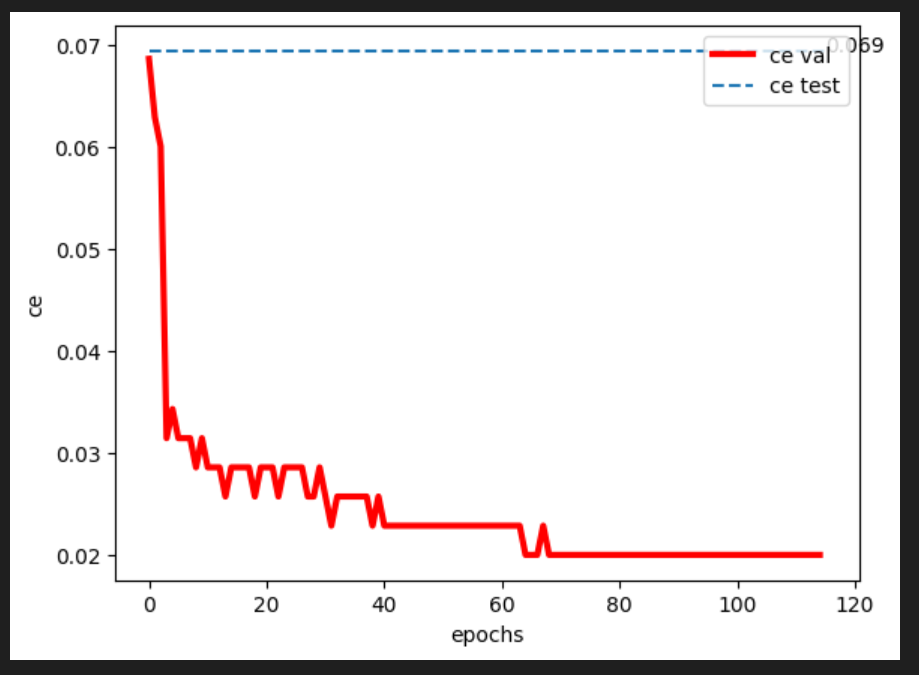
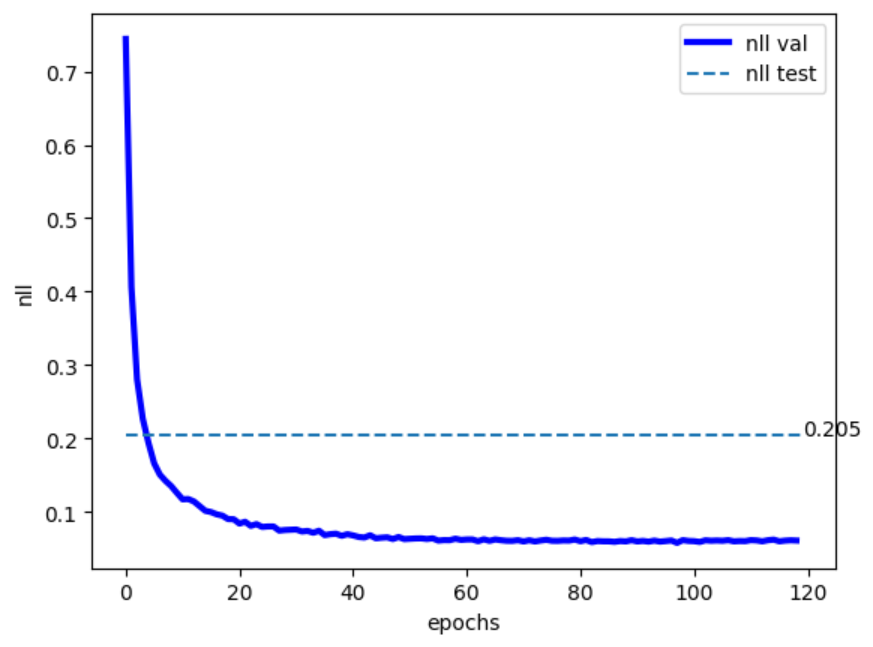
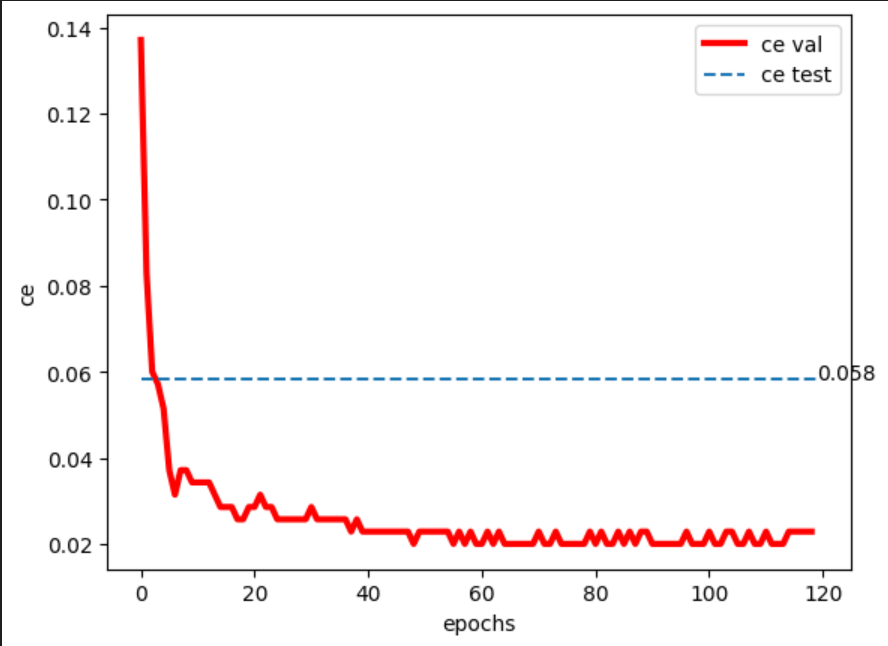

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: In CNN, images have a natural spatial relationship between the pixels. CNNs exploit this by using convolutional layers with shared weights. These layers are able to detect edges, lines and other local features in one part of the image and reuse it elsewhere. MLPs treat the image as a flat vector, losing spatial information. This is just one of many reasons why CNN is better in general. Essentially, CNNs are specifically designed to work with the grid-like structure of images, leveraging spatial relationships and parameter sharing for efficient feature learning and recognition.

![Screenshot 2024-05-15 133231.png](<attachment:Screenshot 2024-05-15 133231.png>)
![Screenshot 2024-05-15 133239.png](<attachment:Screenshot 2024-05-15 133239.png>)
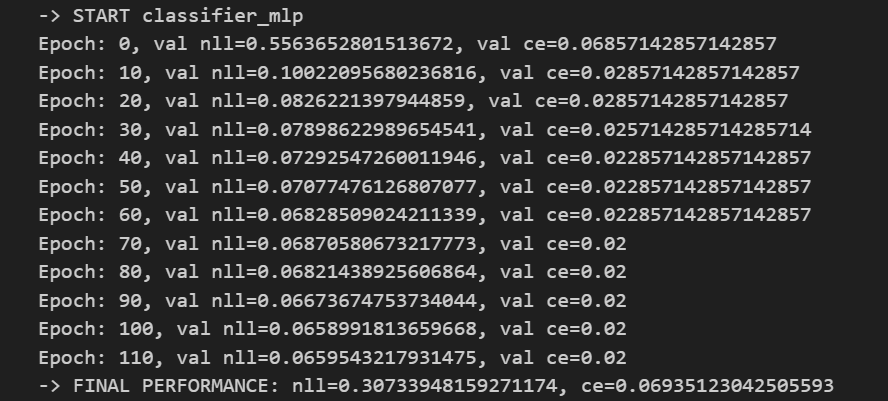
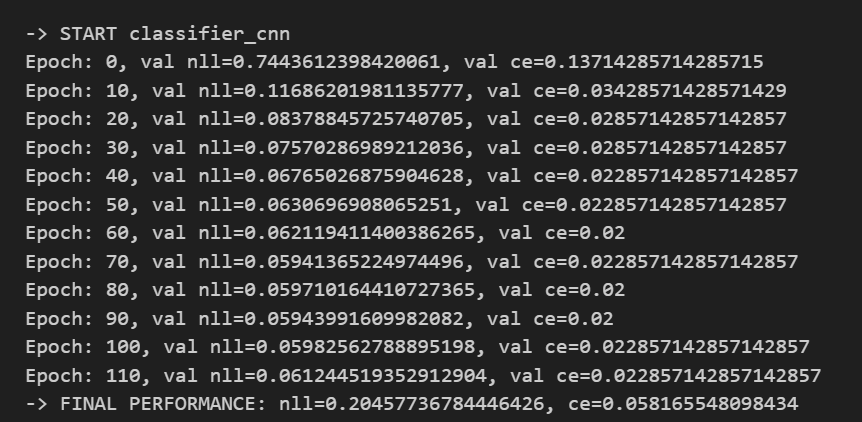

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

In [39]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, Dataset
# custom dataset for the svhn dataset
class SVHN(Dataset): # inherit from torch.utils.data.Dataset
    def __init__(self, root, mode='train', transform=None, val_ratio=0.2): # constructor
        self.mode = mode
        self.dataset = datasets.SVHN(root=root, split='train', transform=transform, download=True) # load the dataset
        self.train_dataset, self.val_dataset = self._split_train_val(self.dataset, val_ratio) # split the dataset

    def __len__(self): # return the length of the dataset
        dataset = self.train_dataset if self.mode == 'train' else self.val_dataset # get the dataset
        return len(dataset) # return the length of the dataset

    def __getitem__(self, index): # get an item from the dataset
        dataset = self.train_dataset if self.mode == 'train' else self.val_dataset # get the dataset
        return dataset[index] # return the item


    def _split_train_val(self, dataset, val_ratio): # split the dataset into training and validation sets
        num_samples = len(dataset) # get the number of samples
        val_size = int(num_samples * val_ratio) # calculate the size of the validation set
        train_size = num_samples - val_size # calculate the size of the training set
        return random_split(dataset, [train_size, val_size]) # return the training and validation sets

def show_images(images, labels): # function to show images
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3)) # create a figure with subplots
    for i, (image, label) in enumerate(zip(images, labels)): # iterate over the images and labels
        axes[i].imshow(image.permute(1, 2, 0)) # show the image
        axes[i].set_title(f"Label: {label}") # set the title
        axes[i].axis("off")
    plt.show()

transform = transforms.ToTensor() # transform to tensor




In [34]:
train_dataset = SVHN(root=results_dir, mode='train', transform=transform, val_ratio=0.2) # 20% of the training data will be used for validation
train_loader_svh = DataLoader(train_dataset, batch_size=64, shuffle=True) # shuffle the training data
val_loader = DataLoader(train_dataset.val_dataset, batch_size=64, shuffle=False)   # do not shuffle the validation data

test_dataset = SVHN(root=results_dir, mode='test', transform=transform) # test data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) # do not shuffle the test data

for loader, name in zip([train_loader_svh, val_loader, test_loader], ['Train', 'Validation', 'Test']): # loop over the loaders
    for batch_idx, (data, targets) in enumerate(loader): # loop over the batches
        print(f"{name} Batch {batch_idx + 1}: {data.shape}") # print the shape of the batch


Using downloaded and verified file: /content/gdrive/My_Drive/Colab Notebooks/TEACHING/train_32x32.mat
Using downloaded and verified file: /content/gdrive/My_Drive/Colab Notebooks/TEACHING/train_32x32.mat
Train Batch 1: torch.Size([64, 3, 32, 32])
Train Batch 2: torch.Size([64, 3, 32, 32])
Train Batch 3: torch.Size([64, 3, 32, 32])
Train Batch 4: torch.Size([64, 3, 32, 32])
Train Batch 5: torch.Size([64, 3, 32, 32])
Train Batch 6: torch.Size([64, 3, 32, 32])
Train Batch 7: torch.Size([64, 3, 32, 32])
Train Batch 8: torch.Size([64, 3, 32, 32])
Train Batch 9: torch.Size([64, 3, 32, 32])
Train Batch 10: torch.Size([64, 3, 32, 32])
Train Batch 11: torch.Size([64, 3, 32, 32])
Train Batch 12: torch.Size([64, 3, 32, 32])
Train Batch 13: torch.Size([64, 3, 32, 32])
Train Batch 14: torch.Size([64, 3, 32, 32])
Train Batch 15: torch.Size([64, 3, 32, 32])
Train Batch 16: torch.Size([64, 3, 32, 32])
Train Batch 17: torch.Size([64, 3, 32, 32])
Train Batch 18: torch.Size([64, 3, 32, 32])
Train Batch 1

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


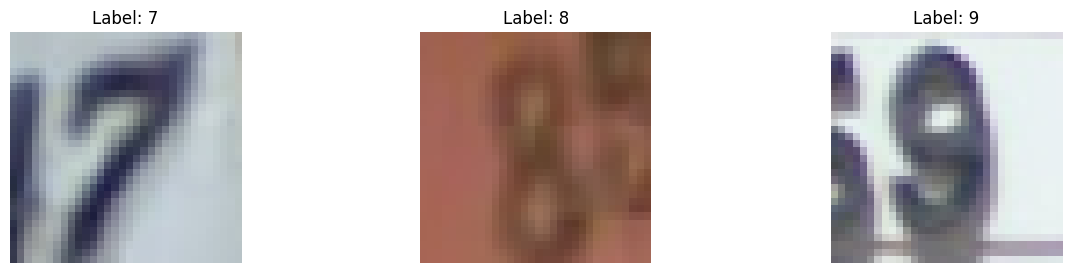

In [41]:
import matplotlib.pyplot as plt

# load 3 omages
batch_size = 3 # number of images to load
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create a dataloader

images, labels = next(iter(train_loader)) # get the next batch of images and labels


def show_images(images, labels): # function to plot images
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3)) # create a figure with subplots
    for i, (image, label) in enumerate(zip(images, labels)): # loop over images and labels
        print(image.shape) # print the shape of the image
        axes[i].imshow(image.permute(1, 2, 0))  # plot the image
        axes[i].set_title(f"Label: {label}") # set the title of the image
        axes[i].axis("off") # turn off the axis
    plt.show() # show the plot


show_images(images, labels) # plot the images

In [45]:
class Hyperparameters:
    def __init__(self, learning_rate, weight_decay, num_epochs, max_patience): # constructor
        self.lr = learning_rate # learning rate
        self.wd = weight_decay # weight decay
        self.num_epochs = num_epochs # number of epochs
        self.max_patience = max_patience # max patience for early stopping

svhn_hyperparams = Hyperparameters(learning_rate=1e-3, weight_decay=1e-5, num_epochs=1000, max_patience=20) # create an instance of Hyperparameters

Epoch: 0, val nll=1.8639589283264715, val ce=0.6903965599617774
Epoch: 10, val nll=0.42443258765126063, val ce=0.1250426592041499
Epoch: 20, val nll=0.3906913124557307, val ce=0.10907105317043206
Epoch: 30, val nll=0.45824604865658625, val ce=0.1095488362569108
-> FINAL PERFORMANCE: nll=0.26480062083899875, ce=0.07869769981571224


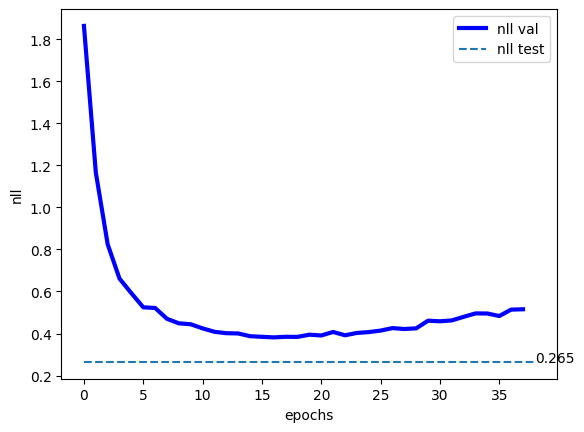

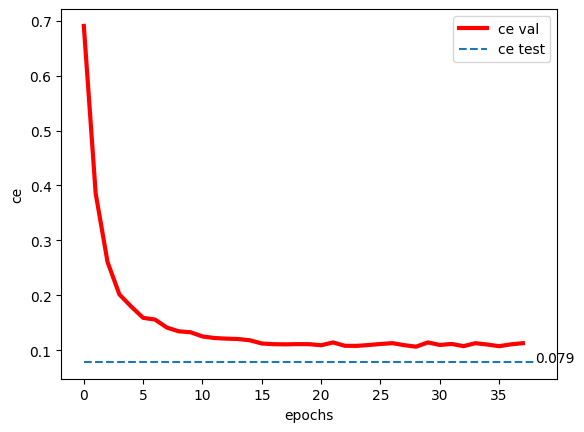

In [48]:
name = f"classifier_svh_M_{M}"

# Ensure result directory exists
result_dir = os.path.join(results_dir, "results", name) # create a path to the results directory
os.makedirs(result_dir, exist_ok=True) # create the directory if it doesn't exist

# CNN

   

classnet = nn.Sequential( # create a sequential model
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), 
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(), # flatten the output
    nn.LazyLinear(out_features=10), nn.LogSoftmax(dim=1) # output layer
)

model = ClassifierNeuralNet(classnet) # create an instance of ClassifierNeuralNet

optimizer = torch.optim.Adamax( # create an optimizer
    [p for p in model.parameters() if p.requires_grad], # parameters to optimize
    lr=lr,
    weight_decay=wd,
)

nll_val, error_val = training( # train the model
    name=os.path.join(result_dir, name), # name of the model
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=train_loader_svh,
    val_loader=val_loader,
)

test_loss, test_error = evaluation(name=os.path.join(result_dir, name), test_loader=test_loader) # evaluate the model on the test set

with open(os.path.join(result_dir, f"{name}_test_loss.txt"), "w") as f: # write the results to a file
    f.write(f"NLL: {test_loss}\nCE: {test_error}")

plot_curve( # plot the curves
    os.path.join(result_dir, name),
    nll_val,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    os.path.join(result_dir, name),
    error_val,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)